In [ ]:
# data

# birthweights of twins - twin0, twin1 - grams (thousands)

# mortality of twins - twin0, twin1 - binary 1/0

# 50 features related to health/birth risk factors of the mother

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
import os

def twins_data():
    twin_pairs_dfs = []

    for file in os.listdir('../data/'):
        if 'twin_pairs' in file:
            df = pd.read_csv(f"../data/{file}")
            unwanted_columns = [col for col in df.columns if 'Unnamed' in col]
            df.drop(columns=unwanted_columns,inplace=True)
            twin_pairs_dfs.append(df)

    df = pd.concat(twin_pairs_dfs, axis=1)

    return df


In [2]:
df = twins_data()

df.head(3)

,dbirwt_0,dbirwt_1,mort_0,mort_1,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,...,feduc6,infant_id_0,infant_id_1,dlivord_min,dtotord_min,bord_0,bord_1,brstate_reg,stoccfipb_reg,mplbir_reg
0,2268.0,2296.0,0.0,0.0,1.0,1.0,1,1,3,0.0,...,NaN,1,0,NaN,NaN,NaN,NaN,5,5,1.0
1,2610.0,2650.0,0.0,0.0,1.0,1.0,1,1,3,0.0,...,NaN,7,6,2.0,3.0,2.0,1.0,5,5,5.0
2,1985.0,2098.0,0.0,0.0,1.0,1.0,1,1,5,0.0,...,3.0,11,10,NaN,NaN,NaN,NaN,5,5,1.0


In [5]:
# we're going to talk about interaction effects i.e. "what is the interaction between predictors x1 and x2"

# but first - starting simple

# dependent/target variable is going to be the combined birthweight of the twins
# ML - target (y)
# trad/stats - dependent (y)

# not a perfect measure of health, but good enough

# independent/feature variables
# one binary - tobacco
# one continuous/integer - total number of birth before the current one (twins)

df['combined_weight'] = df['dbirwt_0'] + df['dbirwt_1']

In [6]:
# combined_weight ~ tobacco

result = smf.ols("combined_weight ~ tobacco",data = df[['combined_weight','tobacco']]).fit()
result.params


Intercept    4853.475575
tobacco      -391.497367
dtype: float64

In [ ]:
# predicted y = intercept + weight_of_x*x

# predicted combined weight = 4853 - 391*tobacco{1,0}

# for someone who smokes

# predicted combined weight = 4853 - 391*1 = 4853 - 391 = 4462

# for someone who does not smoke

# predicted combined weight = 4853 - 391*0 = 4853

In [9]:
df[~df['tobacco'].isna()].groupby('tobacco')['combined_weight'].mean()

tobacco
0.0    4853.475575
1.0    4461.978207
Name: combined_weight, dtype: float64

In [14]:
# combined_weight ~ tobacco + number_of_prior_births

df.rename(columns={"dtotord_min":"number_of_prior_births"},inplace=True)

In [16]:
df['number_of_prior_births'].isna().sum()

7318

In [17]:
df['number_of_prior_births'].describe() # leverage

count    64027.000000
mean         2.510082
std          1.592072
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         21.000000
Name: number_of_prior_births, dtype: float64

In [18]:
df['number_of_prior_births'].fillna(0,inplace=True)
df['number_of_prior_births'].isna().sum()

0

In [19]:
regression_2_columns = ['combined_weight','tobacco','number_of_prior_births']
result = smf.ols("combined_weight ~ tobacco + number_of_prior_births",data = df[regression_2_columns]).fit()
result.params

Intercept                 4740.043471
tobacco                   -420.000603
number_of_prior_births      52.022326
dtype: float64

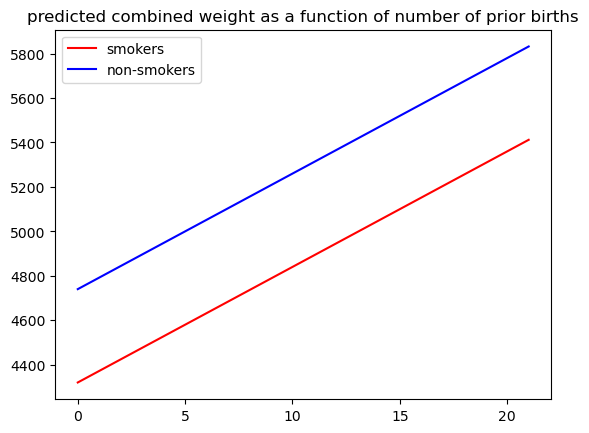

In [20]:
# predicted y = intercept + weight_for_x1*x1 + weight_for_x2*x2

# predicted combined weight = 4740 - 420*tobacco + 52*number_of_prior_births

# for smokers

# 4740 - 420*1 + 52*number_of_prior_births

# 4320 + 52*number_of_prior_births

# for non-smokers
# 4740 + 52*number_of_prior_births

number_of_prior_births_range = np.arange(0,22)

combined_weight_predicted_smokers = 4320 + 52*number_of_prior_births_range

combined_weight_predicted_nonsmokers = 4740 + 52*number_of_prior_births_range

plt.figure()
plt.plot(number_of_prior_births_range,combined_weight_predicted_smokers,c = "red",label = "smokers")
plt.plot(number_of_prior_births_range,combined_weight_predicted_nonsmokers,c = "blue",label = "non-smokers")
plt.title("predicted combined weight as a function of number of prior births")
plt.legend()
plt.show()




In [21]:
# interaction term

result = smf.ols("combined_weight ~ tobacco*number_of_prior_births",data = df[regression_2_columns]).fit()
result.params

Intercept                         4710.300989
tobacco                           -252.368422
number_of_prior_births              65.662848
tobacco:number_of_prior_births     -64.180035
dtype: float64

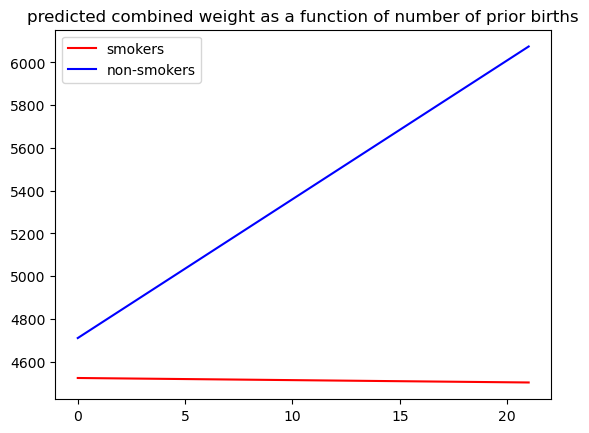

In [22]:
# tobacco -> weight
# tobacco -> number of prior births -> weight

# non-smokers

# 4710 + 65*number_of_prior_births

# smokers

# 4458 + 65*number_of_prior_births - 64*number_of_prior_births = 4523 - number_of_prior_births


number_of_prior_births_range = np.arange(0,22)

combined_weight_predicted_smokers = 4523 - number_of_prior_births_range

combined_weight_predicted_nonsmokers = 4710 + 65*number_of_prior_births_range

plt.figure()
plt.plot(number_of_prior_births_range,combined_weight_predicted_smokers,c = "red",label = "smokers")
plt.plot(number_of_prior_births_range,combined_weight_predicted_nonsmokers,c = "blue",label = "non-smokers")
plt.title("predicted combined weight as a function of number of prior births")
plt.legend()
plt.show()


